**0. Imports**

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import os

**1. Define PDF Function**

In [2]:
# Function to compute intensity values
def gaussian_pdf(rt, mz_array, center_rt, center_mz, sigma_rt, sigma_mz, amplitude=1):
    rt_gauss = np.exp(-0.5 * ((rt - center_rt) / sigma_rt) ** 2)
    mz_gauss = np.exp(-0.5 * ((mz_array - center_mz) / sigma_mz) ** 2)
    intensity = amplitude * (1/(2*np.pi*sigma_mz*sigma_rt)) * rt_gauss * mz_gauss
    return intensity

**2. Define Gaussian Creation Function**

In [3]:
def create_grid_with_gaussian(rt_axis: pd.Series, mz_axis: pd.Series, peak_params: list):
    # Initialize empty list to store intensity values
    intensities = []

    # Loop through each rt value and the corresponding mz values
    for rt_val, mz_array in zip(rt_axis, mz_axis):
        # Convert mz array
        mz_array = np.array(mz_array)

        # Initialize intensity for this particular rt value (list of zeros)
        raw_intensity = np.zeros_like(mz_array, dtype=float)
        
        # print(rt_val, mz_array[0:5])  # Debugging line to check rt and mz values

        # Compute intensity for each peak and accumulate it
        for peak in peak_params:
            rt_center = peak["rt_center"]
            mz_center = peak["mz_center"]
            rt_sigma = peak["rt_sigma"]
            mz_sigma = peak["mz_sigma"]
            amplitude = peak["amplitude"]
        
            # Apply the Gaussian function for the current peak
            peak_intensity = gaussian_pdf(rt_val, mz_array, rt_center, mz_center, rt_sigma, mz_sigma, amplitude)

            # Add the peak intensities to the raw's intensity
            raw_intensity += peak_intensity  # Sum intensities for this mz value

        # Append the summed intensities for this row (as a list of values)
        intensities.append(raw_intensity.tolist())  # Convert to list
        # print(intensities[0:5][0:5])

    # Convert the intensities list to a DataFrame, with each rt value corresponding to a row
    intensity_df = pd.DataFrame({
        "rt": rt_axis,
        "mz": mz_axis,
        "intensities": intensities
    })

    return intensity_df

In [8]:
import numpy as np
import pandas as pd

# Function to compute intensity values
def gaussian_pdf(rt, mz_array, center_rt, center_mz, sigma_rt, sigma_mz, amplitude=1):
    rt_gauss = np.exp(-0.5 * ((rt - center_rt) / sigma_rt) ** 2)
    mz_gauss = np.exp(-0.5 * ((mz_array - center_mz) / sigma_mz) ** 2)
    intensity = amplitude * (1/(2*np.pi*sigma_mz*sigma_rt)) * rt_gauss * mz_gauss
    return intensity

# Function to create grid with Gaussian peaks and added noise
def create_grid_with_gaussian_noisy(rt_axis: pd.Series, mz_axis: pd.Series, peak_params: list, noise_std=0.01):
    intensities = []

    for rt_val, mz_array in zip(rt_axis, mz_axis):
        mz_array = np.array(mz_array)
        raw_intensity = np.zeros_like(mz_array, dtype=float)

        for peak in peak_params:
            rt_center = peak["rt_center"]
            mz_center = peak["mz_center"]
            rt_sigma = peak["rt_sigma"]
            mz_sigma = peak["mz_sigma"]
            amplitude = peak["amplitude"]

            peak_intensity = gaussian_pdf(rt_val, mz_array, rt_center, mz_center, rt_sigma, mz_sigma, amplitude)
            raw_intensity += peak_intensity

        # Add Gaussian noise
        noise = np.random.normal(loc=0, scale=noise_std, size=raw_intensity.shape)
        noisy_intensity = raw_intensity + noise

        # Make sure no intensities go negative
        noisy_intensity = np.clip(noisy_intensity, 0, None)

        intensities.append(noisy_intensity.tolist())

    intensity_df = pd.DataFrame({
        "rt": rt_axis,
        "mz": mz_axis,
        "intensities": intensities
    })

    return intensity_df


**3. Import Grid**

In [4]:
# Import JSON Grid
grid = pd.read_json("v2_grid.json")

# Define Axes
rt_axis = grid["rt"]
mz_axis = grid["mz"]

grid.head()

,rt,mz
0,10.000000,"[150, 150.0095141891, 150.020400515, 150.03059..."
1,10.056727,"[150, 150.0087047019, 150.0196320591, 150.0282..."
2,10.113530,"[150, 150.0109749417, 150.0206152599, 150.0320..."
3,10.164866,"[150, 150.008555188, 150.0183029892, 150.02919..."
4,10.224504,"[150, 150.0117885405, 150.0222033668, 150.0313..."


**4. Define Gaussians**

In [24]:
# Define peak
peak_params = [
    {"rt_center": 11.5, "mz_center": 152.1, "rt_sigma": 0.1, "mz_sigma": 0.03, "amplitude": 10000},
    {"rt_center": 12.0, "mz_center": 153.0, "rt_sigma": 0.15, "mz_sigma": 0.025, "amplitude": 25000},
    {"rt_center": 13.0, "mz_center": 154.5, "rt_sigma": 0.2, "mz_sigma": 0.04, "amplitude": 18000},
    {"rt_center": 12.25, "mz_center": 153.12, "rt_sigma": 0.15, "mz_sigma": 0.025, "amplitude": 20000},
    {"rt_center": 13.35, "mz_center": 154.425, "rt_sigma": 0.2, "mz_sigma": 0.04, "amplitude": 45000},
    # Adding more is possible
]

**5. Generate Gaussians Inside Grid**

In [25]:
grid_gaussians = create_grid_with_gaussian_noisy(rt_axis=rt_axis, mz_axis=mz_axis, peak_params=peak_params)

grid_gaussians.head()

,rt,mz,intensities
0,10.000000,"[150, 150.0095141891, 150.020400515, 150.03059...","[0.008748758213720903, 0.0, 0.0012102302423900..."
1,10.056727,"[150, 150.0087047019, 150.0196320591, 150.0282...","[0.0, 0.005745826536905764, 0.0048658649675485..."
2,10.113530,"[150, 150.0109749417, 150.0206152599, 150.0320...","[0.00857406572073303, 0.013202611261118768, 0...."
3,10.164866,"[150, 150.008555188, 150.0183029892, 150.02919...","[0.010036094348903006, 0.007749113208253122, 0..."
4,10.224504,"[150, 150.0117885405, 150.0222033668, 150.0313...","[0.0031518714862140995, 0.0011254952581199378,..."


**6. Plot Results 2D**

Heatmap size:  (1000, 100)


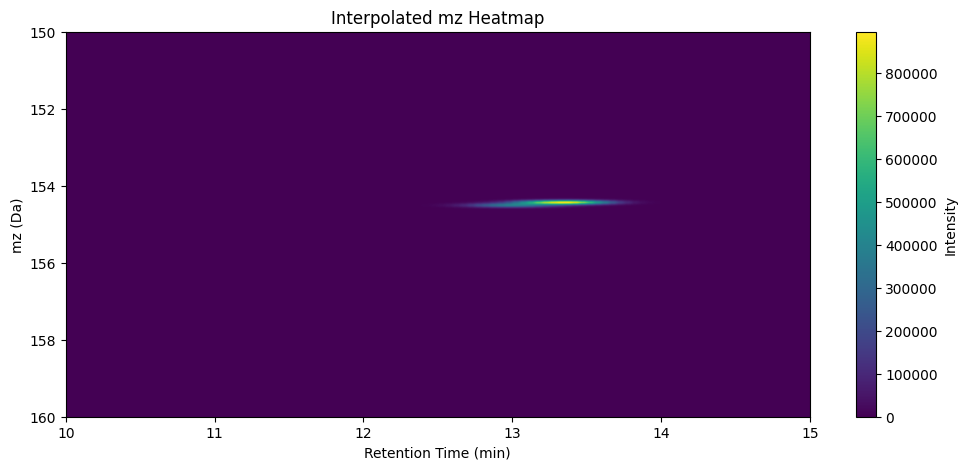

In [11]:
from scipy.interpolate import interp1d

def plot_heatmap_from_irregular_data(df, title="Interpolated mz Heatmap", zoom=False, mz_points=1000):
    # Step 1: Get rt values
    rt_values = df["rt"].values
    # rt_values_edge = np.linspace(rt_values.min(), rt_values.max(), 1000)

    # Step 2: Define a common mz grid over full range
    all_mz = np.concatenate(df["mz"].values)
    mz_min, mz_max = all_mz.min(), all_mz.max()
    common_mz = np.linspace(mz_min, mz_max, mz_points)

    # Step 3: Interpolate each mz-intensity pair to the common mz grid
    interpolated_matrix = []
    for mz, intensity in zip(df["mz"], df["intensities"]):
        mz = np.array(mz)
        intensity = np.array(intensity).flatten()  # <- flatten here

        interp = interp1d(mz, intensity, kind='linear', bounds_error=False, fill_value=0)
        interpolated_intensity = interp(common_mz)
        interpolated_matrix.append(interpolated_intensity)

    intensity_matrix = np.array(interpolated_matrix)
    intensity_matrix = intensity_matrix.T  # Transpose to have rt as rows and mz as columns
    
    # print("Rt and mz length: ", len(rt_edges), len(mz_edges))
    print("Heatmap size: ", intensity_matrix.shape)

    # Step 4: Plot heatmap
    plt.figure(figsize=(12, 5))
    plt.imshow(intensity_matrix,
        extent=[rt_values[0], rt_values[-1], common_mz[-1], common_mz[0]],
        aspect='auto',
        cmap='viridis')
    plt.colorbar(label='Intensity')
    plt.xlabel('Retention Time (min)')
    plt.ylabel('mz (Da)')
    plt.title(title)

    # Optional zoom
    if zoom:
        plt.xlim(zoom.get('xlim', (rt_values[0], rt_values[-1])))
        plt.ylim(zoom.get('ylim', (common_mz[0], common_mz[-1])))

    plt.show()
    
    fig = px.imshow(
        intensity_matrix,
        origin='lower',
        aspect='auto',
        labels=dict(x="Retention Time", y="m/z", color="Intensity"),
        x=rt_values,
        y=common_mz,
        color_continuous_scale="Viridis"
    )
    fig.update_layout(title="2D Image Plot of LC-MS Data",
        width=800,       # ← set your desired width in pixels
        height=600)
    fig.show()


plot_heatmap_from_irregular_data(df=grid_gaussians)

**7. Plot Results 3D**

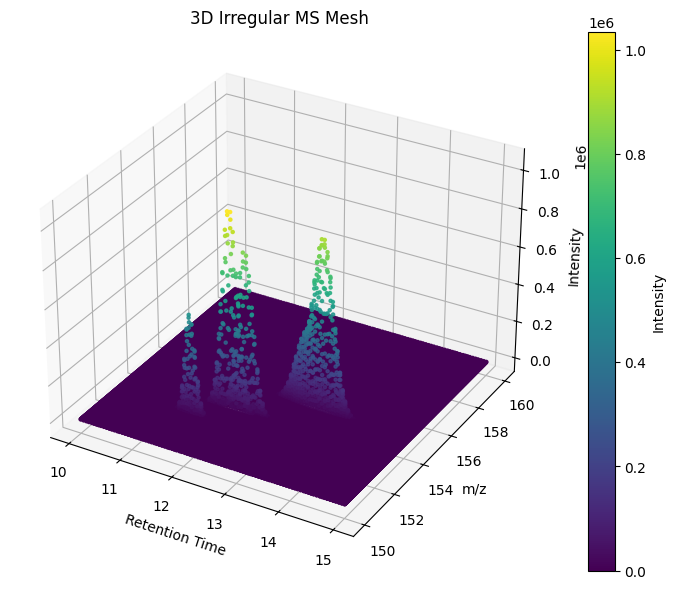

In [8]:
def plot_3d_irregular_mesh(df):
    rt_list = []
    mz_list = []
    intensity_list = []

    for _, row in df.iterrows():
        rt = row['rt']
        mz_values = row['mz']
        intensity_values = row['intensities']

        if len(mz_values) != len(intensity_values):
            raise ValueError("Length mismatch between mz and intensity in row.")

        rt_list.extend([rt] * len(mz_values))
        mz_list.extend(mz_values)
        intensity_list.extend(intensity_values)

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(rt_list, mz_list, intensity_list, c=intensity_list, cmap='viridis', s=5)
    
    ax.set_xlabel("Retention Time")
    ax.set_ylabel("m/z")
    ax.set_zlabel("Intensity")
    fig.colorbar(scatter, ax=ax, label='Intensity')
    plt.title("3D Irregular MS Mesh")
    plt.show()

plot_3d_irregular_mesh(df=grid_gaussians)

**8. Export to JSON**

In [ ]:
import os
def save_gaussians_grid(df, base_filename="gaussians_grid"):
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)
    
    # Start with the base path
    filename = f"{base_filename}.json"
    filepath = os.path.join(output_folder, filename)
    counter = 1

    # Check if the file already exists and increment the counter if it does
    while os.path.exists(filepath):
        filename = f"{base_filename}_{counter}.json"
        filepath = os.path.join(output_folder, filename)
        counter += 1

    # Save the dataframe to the unique filepath
    df.to_json(filepath, index=False)
    print(f"File saved as: {filepath}")

save_gaussians_grid(grid_gaussians)

TypeError: 'module' object is not callable

**8. Export to mzXML (WORK NEEDED)**

Specify MS1 and MS2

In [29]:
from pyopenms import MSExperiment, MzMLFile, MSSpectrum

def write_df_to_mzml(df, output_path_base="output.mzML"):

    df_prepped = df.rename(columns={
    "rt": "RT",
    "mz": "mzarray",
    "intensities": "intarray"
    })

    # Handle file name bumping
    base, ext = os.path.splitext(output_path_base)
    output_path = output_path_base
    count = 1
    while os.path.exists(output_path):
        output_path = f"{base}_{count}{ext}"
        count += 1

    print(f"Saving to: {output_path}")


    exp = MSExperiment()

    for i, row in df_prepped.iterrows():
        spectrum = MSSpectrum()
        spectrum.setRT(row["RT"])  # in seconds
        spectrum.setMSLevel(1)
        spectrum.set_peaks([row["mzarray"], row["intarray"]])  # m/z and intensity arrays
        exp.addSpectrum(spectrum)
    MzMLFile().store(output_path, exp)
    print("DONE")


write_df_to_mzml(grid_gaussians, "output_back.mzML")

Saving to: output_back_1.mzML
DONE


# TEST Import

In [23]:
def load_mzml_file(file_path):
    experiment = MSExperiment()
    MzMLFile().load(file_path, experiment)
    data_loaded = experiment.get_df()
    return experiment, data_loaded

# Load the mzML file
file_path = "C:\\Users\\victo\\VSCode Folder\\UMCG Mass Spec\\Thesis\\PeakSeparationThesis\\GenData\\output_back.mzML"
experiment, data_loaded = load_mzml_file(file_path)
print(data_loaded.head())
print(data_loaded.describe())

data_loaded.to_csv("data_loaded")

          RT                                            mzarray  \
0  10.000000  [150.0, 150.0095141891, 150.020400515, 150.030...   
1  10.056727  [150.0, 150.0087047019, 150.0196320591, 150.02...   
2  10.113530  [150.0, 150.0109749417, 150.0206152599, 150.03...   
3  10.164866  [150.0, 150.008555188, 150.0183029892, 150.029...   
4  10.224504  [150.0, 150.0117885405, 150.0222033668, 150.03...   

                                            intarray  
0  [0.0036806795, 0.018141478, 0.01201513, 0.0, 0...  
1  [0.0070882826, 0.0, 0.0, 0.015497836, 0.0, 0.0...  
2  [0.009309768, 0.0, 0.0, 0.0, 0.0, 0.008689513,...  
3  [0.0, 0.0, 0.0009131041, 0.0, 0.0, 0.00853824,...  
4  [0.009562612, 0.0075164014, 0.0140555445, 0.01...  
               RT
count  100.000000
mean    12.506767
std      1.457235
min     10.000000
25%     11.267123
50%     12.509207
75%     13.741018
max     15.000000
